In [1]:
import pandas as pd
from clickhouse_driver import Client
import numpy as np
from tqdm import tqdm_notebook

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from scipy.signal import argrelmin, argrelmax

In [4]:
import networkx as nx

# Ranks filtering 

This page describe a process of reducing the list of ~40M addresses to the list of ~1M addresses.

# Table of contents
1. Initial filtering
2. Addresses with nonzero balances
3. Addresses clustering
4. Where are you, Dmitry?
5. Activity of listed addresses

# Initial filtering

At first, we'll throw out addresses that were inactive during last year. Also, smart contracts were repressed too.

In [188]:
ranks_df = pd.read_csv("./ranks", sep=" ", names=["address", "rank"]).set_index("address")

In [614]:
client = Client("localhost")

In [190]:
active_addresses = client.execute("""
    SELECT distinct(from)
    FROM ethereum_internal_transaction
    WHERE blockNumber > 5000000
    AND value > 0
""")

In [191]:
active_addresses = [a[0] for a in tqdm_notebook(active_addresses) if a[0] in ranks_df.index]

In [192]:
ranks_df = ranks_df.loc[active_addresses]

In [193]:
contracts = client.execute("""
    SELECT address
    FROM ethereum_contract
""")

In [194]:
contracts = [c[0] for c in tqdm_notebook(contracts) if c[0] in ranks_df.index]

In [195]:
ranks_df = ranks_df.drop(contracts)

# Addresses with nonzero balances
Ethereum balance consists of five parts:
1. Income
2. Outcome
3. Fees of outgoing transactions
4. Mining rewards
5. Transaction fees in blocks mined as "blocks", not as "uncles"

We should calculate these values for all addresses in graph and to throw away addresses with close-to-zero balance. Frankly speaking, this is the end point of addresses list formation for the overhelming majority of airdrops.

In [615]:
client.execute("""
    SET max_memory_usage=50000000000
""")

[]

In [197]:
outcome = client.execute("""
    SELECT from, SUM(value) 
    FROM ethereum_internal_transaction 
    WHERE value > 0
    AND error IS NULL
    AND parent_error IS NULL
    GROUP BY from
""")

In [198]:
outcome_df = pd.DataFrame(outcome, columns=["address", "value"])

In [200]:
income = client.execute("""
    SELECT to, SUM(value) 
    FROM ethereum_internal_transaction 
    WHERE value > 0
    AND error IS NULL
    AND parent_error IS NULL
    GROUP BY to
""")

In [201]:
income_df = pd.DataFrame(income, columns=["address", "value"])

In [203]:
mining = client.execute("""
    SELECT author, SUM(value)
    FROM ethereum_internal_transaction 
    GROUP BY author
""")

In [204]:
mining_df = pd.DataFrame(mining, columns=["address", "value"])

In [206]:
paid_fees = client.execute("""
    SELECT from, SUM(fee)
    FROM
    (
        SELECT from, dictGetInt32('transaction_fee', 'gasUsed', tuple(id)) * dictGetFloat64('transaction_fee', 'gasPrice', tuple(id)) AS fee 
        FROM ethereum_internal_transaction 
        WHERE fee > 0
    ) 
    GROUP BY from
""")

In [207]:
paid_fees_df = pd.DataFrame(paid_fees, columns=["address", "value"])

In [209]:
fees = client.execute("""
    SELECT blockHash, author, fee 
    FROM (
        SELECT blockHash, author 
        FROM ethereum_internal_transaction 
        WHERE type='reward' 
        AND rewardType = 'block'
    ) ANY INNER JOIN (
        SELECT blockHash, dictGetInt32('transaction_fee', 'gasUsed', tuple(id)) * dictGetFloat64('transaction_fee', 'gasPrice', tuple(id)) AS fee 
        FROM ethereum_internal_transaction 
        WHERE fee > 0
    ) USING blockHash
""")

In [210]:
fees_df = pd.DataFrame(fees, columns=["block", "address", "value"])

In [211]:
fees_df = fees_df.groupby('address')["value"].sum().to_frame()

In [213]:
balances_df = fees_df.reset_index().merge(mining_df, how="outer", on="address").rename(columns={
    "value_x": "fees",
    "value_y": "reward"
})
balances_df = balances_df.merge(income_df, how="outer", on="address").rename(columns={
    "value": "income"
})
balances_df = balances_df.merge(outcome_df, how="outer", on="address").rename(columns={
    "value": "outcome"
})
balances_df = balances_df.merge(paid_fees_df, how="outer", on="address").rename(columns={
    "value": "paid_fees"
})

In [215]:
balances_df.fillna(0, inplace=True)

In [216]:
balances_df["balance"] = balances_df["income"] + balances_df["reward"] + balances_df["fees"] - balances_df["outcome"] - balances_df["paid_fees"]

In [217]:
balances_df[balances_df["balance"] < -0.01].shape

(236263, 7)

In [221]:
balances_df.to_csv("balances")

In [218]:
addresses_with_nonzero_balance = [address for address in tqdm_notebook(balances_df[balances_df["balance"] > 0.001]["address"]) if address in ranks_df.index]

In [219]:
ranks_df = ranks_df.loc[addresses_with_nonzero_balance]

In [220]:
ranks_df.reset_index().to_csv("filtered_ranks", sep=" ", header=False, index=False)

In [226]:
ranks_df.shape

(4164587, 2)

# Addresses clustering

The procedure of list reduction described in a main article goes below. 

In [5]:
ranks_df = pd.read_csv("./filtered_ranks", sep=" ", names=["address", "rank"]).set_index("address")

In [227]:
ranks_df["rounded_rank"] = ranks_df["rank"] * 1000000000 // 100

In [228]:
ranks_df["rounded_rank"].nunique()

1323458

In [229]:
ranks_df["rank"].idxmin()

'0x2ba24c66cbff0bda0e3053ea07325479b3ed1393'

In [230]:
bins = ranks_df.groupby("rounded_rank").size()

In [231]:
bins = bins.to_frame().reset_index()

In [232]:
bins["rounded_rank"] = bins["rounded_rank"] / 10000000

In [233]:
bins.to_csv("./file.csv", sep=" ", header=False, index=False)

In [237]:
ranks_df["value"] = 1

In [240]:
ranks_df[["rank", "value"]].sort_values("rank").to_csv("file.csv", sep=" ", header=False, index=False)

In [6]:
kde_df = pd.read_csv("./result.csv", sep=" ", names=["rank", "kde"])

Нахождение кластеров

In [242]:
kde_df["rank"].min()

-56.6224

In [9]:
from scipy.signal import find_peaks_cwt, find_peaks

In [10]:
from detect_peaks import detect_peaks

In [365]:
# maxids = argrelmax(kde_df["kde"].values)[0]
# minids = argrelmin(kde_df["kde"].values)[0]
# maxids = find_peaks(kde_df["kde"].values)
# minids = argrelmin(kde_df["kde"].values)[0]
# maxids = peakdetect.peakdetect(kde_df["kde"].values)

In [11]:
from scipy import interpolate

In [12]:
grid = np.linspace(kde_df["rank"].quantile(0.0001), kde_df["rank"].quantile(0.9999), kde_df.shape[0])
kde_f = interpolate.interp1d(kde_df["rank"], kde_df["kde"])

In [13]:
normalized_kde_df = pd.DataFrame()
normalized_kde_df["rank"] = grid
normalized_kde_df["kde"] = kde_f(grid)

In [14]:
maxids = normalized_kde_df["kde"].rolling(100, center=True).max() == normalized_kde_df["kde"]
minids = normalized_kde_df["kde"].rolling(100, center=True).min() == normalized_kde_df["kde"]

In [15]:
normalized_kde_df["ismin"] = False
normalized_kde_df.loc[minids, "ismin"] = True
normalized_kde_df.loc[maxids, "ismin"] = False
normalized_kde_df["ismax"] = False
normalized_kde_df.loc[maxids, "ismax"] = True
normalized_kde_df.loc[minids, "ismax"] = False

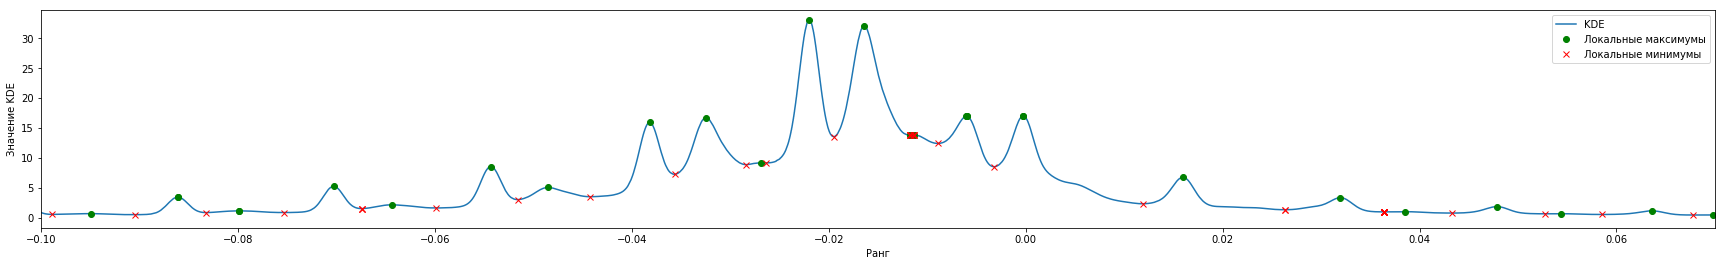

In [19]:
plt.figure(figsize=(30, 4))
plt.plot(normalized_kde_df["rank"], normalized_kde_df["kde"], label="KDE")
plt.plot(normalized_kde_df["rank"][maxids], normalized_kde_df["kde"][maxids], 'o', color="green", label="Локальные максимумы")
plt.plot(normalized_kde_df["rank"][minids], normalized_kde_df["kde"][minids], 'x', color="red", label="Локальные минимумы")
plt.xlim(left=-0.1, right=0.07)
plt.xlabel("Ранг")
plt.ylabel("Значение KDE")
plt.legend()

In [20]:
local_minima = False
local_maxima = False
cluster_size = 0
cluster = 0
MIN_CLUSTER_SIZE = 100
cluster_start = ranks_df["rank"].min()

for i, row in tqdm_notebook(normalized_kde_df.iterrows(), total=normalized_kde_df.shape[0]):
    cluster_size += 1
    if row["ismax"]:
        local_maxima = True
    elif row["ismin"]:
        if local_minima and local_maxima and (cluster_size > MIN_CLUSTER_SIZE):
            cluster_size = 0
            local_maxima = False
            local_minima = False
            ranks_df.loc[(ranks_df["rank"] >= cluster_start) & (ranks_df["rank"] <= row["rank"]), "cluster"] = cluster
            cluster += 1
        if not local_minima:
            local_minima = True
            cluster_start = row["rank"]

In [21]:
ranks_df["cluster"] = ranks_df["cluster"].fillna(cluster + 1)

This part of code is for addresses that are close to local minimas

In [570]:
ADDRESSES_SIZE = 1000000
addresses = []
for cluster in tqdm_notebook(ranks_df["cluster"].unique()):
    cluster_addresses = ranks_df[ranks_df["cluster"] == cluster].sort_values("rank").index.tolist()
    selection_size = int(ADDRESSES_SIZE * len(cluster_addresses) / ranks_df.shape[0] / 2)
    selection_size = max(selection_size, 1)
    addresses += cluster_addresses[:selection_size]
    addresses += cluster_addresses[-selection_size:]

This part of code is for addresses that are close to local maximas

In [22]:
kde_ranks = normalized_kde_df["rank"].tolist()

In [23]:
from bisect import bisect_left, bisect_right

def find_le(a, x):
    'Find rightmost value less than or equal to x'
    i = bisect_right(a, x)
    i = max(i - 1, 0)
    return a[i]

def find_ge(a, x):
    'Find leftmost item greater than or equal to x'
    i = bisect_left(a, x)
    i = min(i, len(a) - 1)
    return a[i]
    
def find_closest(a, x):
    successor = find_ge(a, x)
    predecessor = find_le(a, x)
    if successor - x > x - predecessor:
        return predecessor
    else:
        return successor

In [24]:
ranks_df["kde_rank"] = ranks_df["rank"].apply(lambda x: find_closest(kde_ranks, x))

In [25]:
kde_for_ranks = {row["rank"]: row["kde"] for i, row in tqdm_notebook(normalized_kde_df.iterrows(), total=normalized_kde_df.shape[0])}

In [26]:
ranks_df["kde"] = ranks_df["kde_rank"].apply(lambda x: kde_for_ranks[x])

In [27]:
ADDRESSES_SIZE = 1000000
addresses = []
for cluster in tqdm_notebook(ranks_df["cluster"].unique()):
    cluster_addresses = ranks_df[ranks_df["cluster"] == cluster].sort_values("kde", ascending=False).index.tolist()
    selection_size = int(ADDRESSES_SIZE * len(cluster_addresses) / ranks_df.shape[0])
    selection_size = max(selection_size, 1)
    addresses += cluster_addresses[:selection_size]

# Where are you, Dmitry?

![](https://i0.wp.com/rusmonitor.com/wp-content/uploads/2018/02/ww1474-e1517836960203.jpg)

Seems like during the process of genesis generation we've accidentaly throw away the address of key team members including Dmitry. This is very strange, cause his address was participated in more than 1000 transactions

The future investigation showed that Dmitry got into a cluster centered around one of Bittrex addresses. So the procedure selects most active Bittrex traders from this cluster

In [28]:
filtered_ranks_df = ranks_df.loc[addresses].copy()

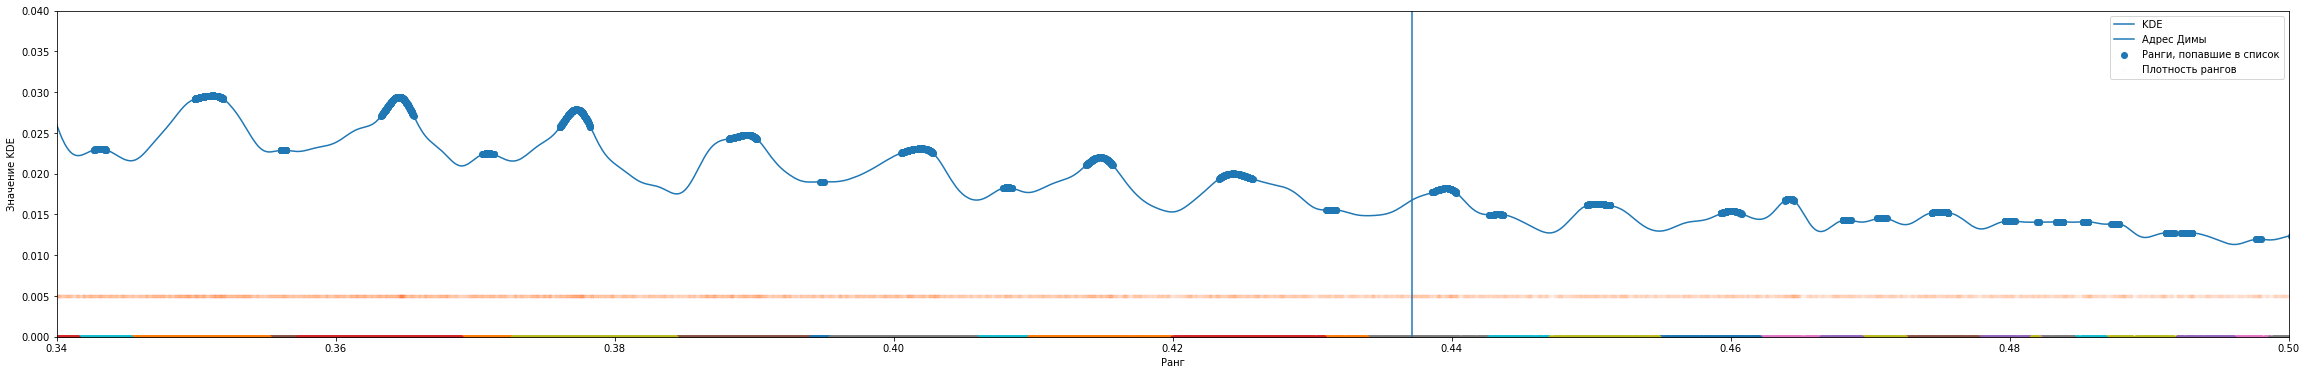

In [34]:
plt.figure(figsize=(40, 6))
# plt.figure(figsize=(20, 3))
plt.plot(kde_df["rank"], kde_df["kde"], label="KDE")
plt.scatter(filtered_ranks_df["rank"], filtered_ranks_df["kde"], label="Ранги, попавшие в список")
plt.scatter(ranks_df["rank"], np.zeros(ranks_df.shape[0]) + 0.005, marker='.', alpha=0.01, label="Плотность рангов")
for cluster in tqdm_notebook(ranks_df["cluster"].unique()):
    cluster_ranks = ranks_df[ranks_df["cluster"] == cluster]["rank"]
    plt.scatter(cluster_ranks, np.zeros(cluster_ranks.shape[0]), marker='.')
plt.axvline(x=ranks_df.loc["(Dmitry's address)".lower()]["rank"], label="Адрес Димы")
plt.xlim(left=0.34, right=0.50)
plt.ylim(0, 0.04)
plt.xlabel("Ранг")
plt.ylabel("Значение KDE")
plt.legend()

In [700]:
filtered_ranks_df.shape

(999776, 6)

In [30]:
filtered_ranks_df["percentage"] = 1 / filtered_ranks_df["kde"]

In [31]:
filtered_ranks_df["percentage"] = filtered_ranks_df["percentage"] / filtered_ranks_df["percentage"].sum()

In [697]:
ranks_df.loc["(Dmitry's address)".lower()]

rank            4.371377e-01
rounded_rank    4.371377e+06
value           1.000000e+00
cluster         2.770000e+02
kde_rank        4.371378e-01
kde             1.675056e-02
Name: 0x7c4401ae98f12ef6de39ae24cf9fc51f80eba16b, dtype: float64

In [599]:
cluster_addresses = ranks_df[ranks_df["cluster"] == 277].sort_values('kde', ascending=False).index

In [603]:
cluster_addresses_string = ",".join(["'{}'".format(a) for a in cluster_addresses])

In [616]:
transactions_in_cluster = client.execute("""
    SELECT from, to, value
    FROM ethereum_internal_transaction
    WHERE (from in({}) OR to in({}))
    AND value > 0
""".format(cluster_addresses_string, cluster_addresses_string))

In [617]:
transactions_in_cluster_df = pd.DataFrame(transactions_in_cluster, columns=["from", "to", "value"])

In [618]:
transactions_in_cluster_df.shape

(6970467, 3)

In [620]:
internal_transactions_df = transactions_in_cluster_df[transactions_in_cluster_df["from"].isin(cluster_addresses) & transactions_in_cluster_df["to"].isin(cluster_addresses)]

In [631]:
graph = nx.DiGraph()
graph.add_edges_from(internal_transactions_df[["from", "to"]].values)

In [692]:
test_frame_df = internal_transactions_df.groupby("to").size().sort_values()

In [693]:
test_frame_df = test_frame_df.to_frame().merge(filtered_ranks_df["kde"].to_frame(), left_index=True, right_index=True)

In [704]:
test_frame_df.sort_values("kde")

,0,kde
0xe651d0107cc442943df1ca3a6d0d601816f19262,9,0.017717
0xe50935e3a26eb402e8a4cf700b24bf8b918daf5d,3,0.017841
0xdcba14a42e0217f1ef1a5405807ab04e8c8473e4,2,0.017915
0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,358,0.017972
0x68c4f3cfdfdba7384967fad112cd1e8cf01a7fc9,1,0.017984
0x40a2bdf789a8e3b9fc68d2f6a5bb670fcfc21bc4,1,0.017994
0xefbe55e1d417224f271e95cbc0f3063246fe3252,3,0.018008
0x5a0ff446b1c41ff5066d2942bfee8eb8b9bb5cc5,32,0.018015
0x1525c3ee444a5258d61cd53c8ad2c1b5fdb85d83,1,0.018026
0x2e7e8f45b240ce471b1981ae4062d32ca7939374,9,0.018045


{'0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98': Text(0.02713659391046039, 0.011790159792017307, 'Bittrex')}

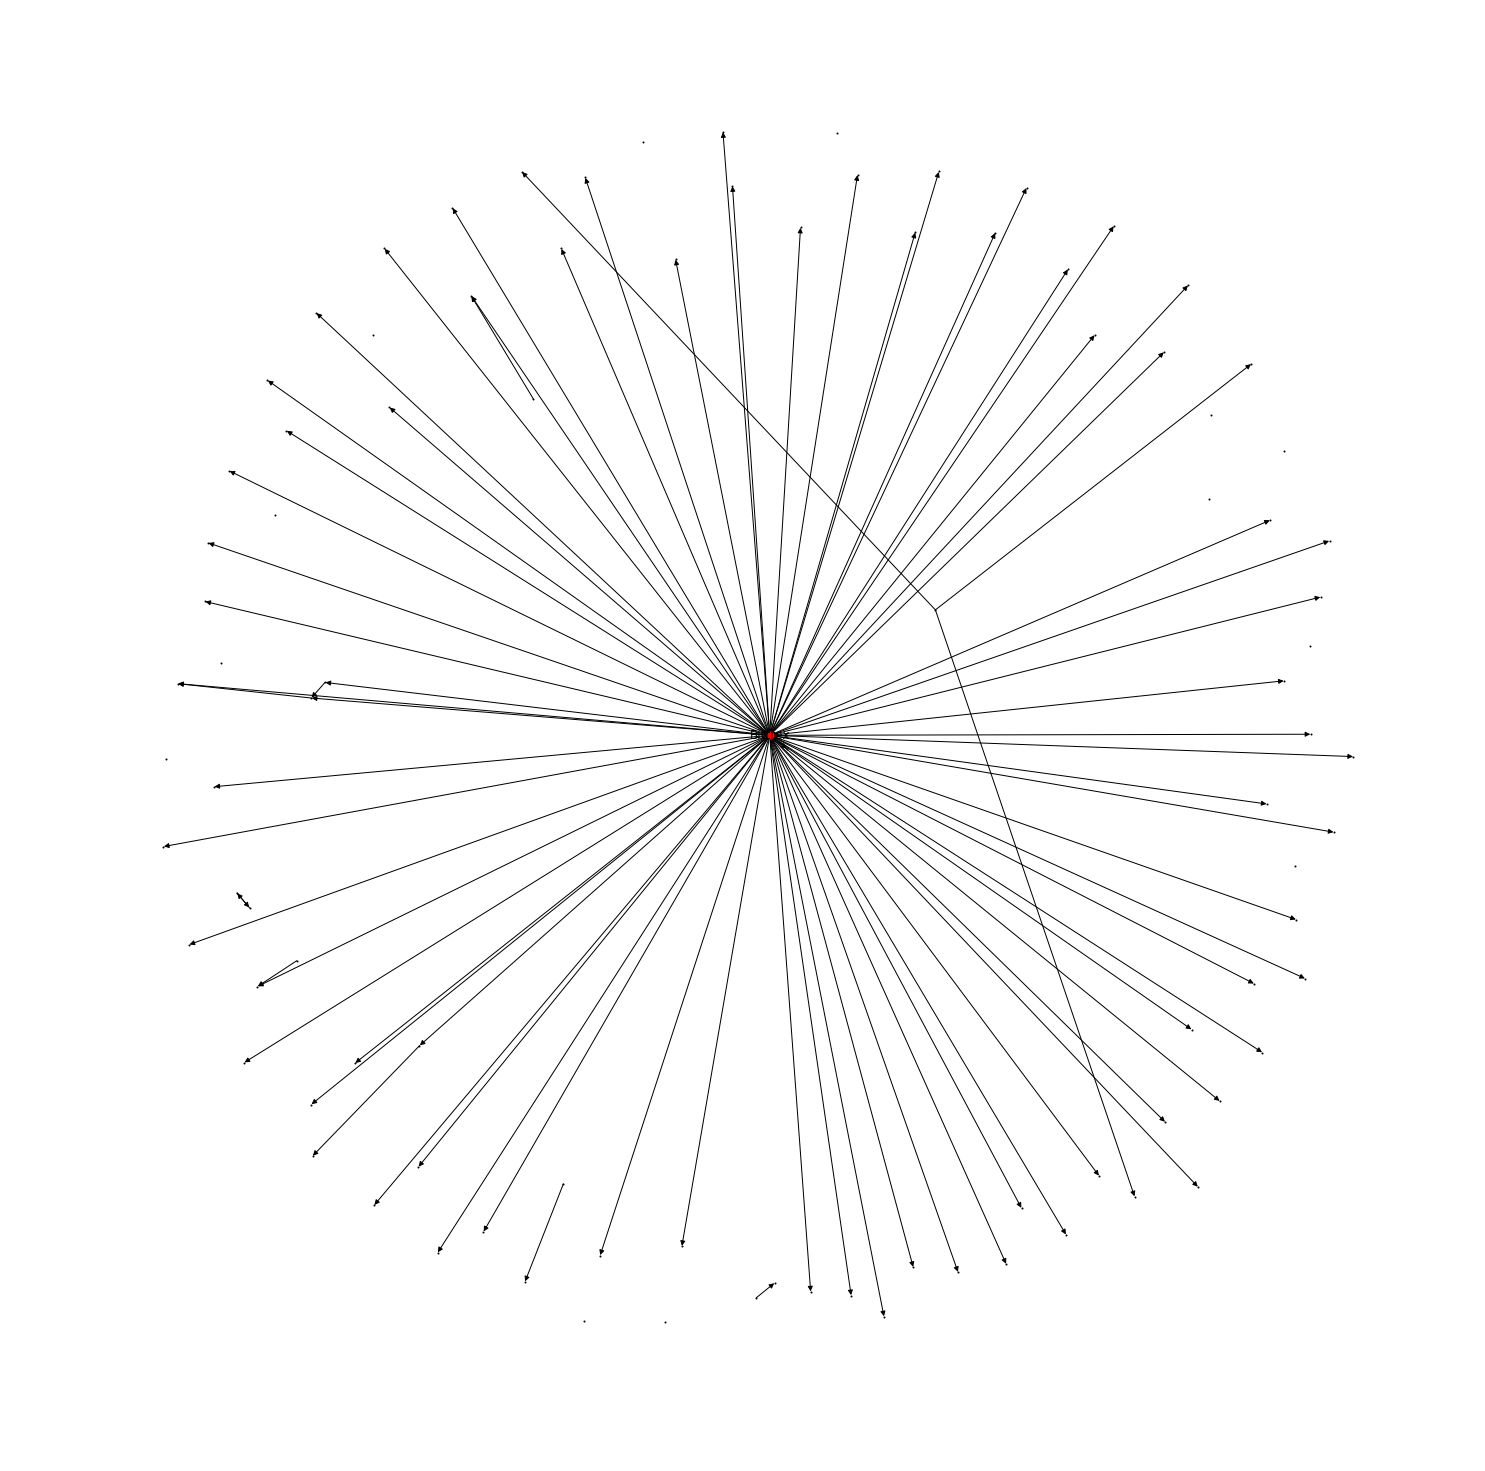

In [716]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_size=1, node_color='black')
nx.draw_networkx_nodes(graph, pos, nodelist=["0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98".lower()], node_size=50, node_color="red")
nx.draw_networkx_labels(graph, pos, labels={"0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98".lower(): "Bittrex"}, node_size=10, node_color="red")

In [546]:
filtered_ranks_df.sort_values("percentage", ascending=False)

,rank,rounded_rank,value,cluster,kde_rank,kde,percentage
address,,,,,,,
0x89dfeb37dc82b4e46b4af66967f98e2b0238e9ba,-1.146035,-11460346.0,1,23.0,-1.146034,0.000847,0.000453
0xf1288c2a07bb08a52f965da7fa73aad1a68aa0d3,-1.146083,-11460832.0,1,23.0,-1.146083,0.000847,0.000453
0x1d50588c0aa11959a5c28831ce3dc5f1d3120d29,-1.288115,-12881155.0,1,1.0,-1.269468,0.000862,0.000445
0x2d7ba8aad4be5493a2df377026b1e1a9ceabe141,-1.301037,-13010368.0,1,1.0,-1.269468,0.000862,0.000445
0x3f9120f405584412e88be0e6f5a22adfb25e265a,-1.275462,-12754616.0,1,1.0,-1.269468,0.000862,0.000445
0x17adce83b7fefac05683521b71cf0dfd1c603e3d,-1.369829,-13698295.0,1,1.0,-1.269468,0.000862,0.000445
0xd959d33341d64847c8cd9f47418f8253bb872374,-1.281538,-12815384.0,1,1.0,-1.269468,0.000862,0.000445
0xf02c5b5a9afba1e914184a3879bda203ad23e7c0,-1.294334,-12943339.0,1,1.0,-1.269468,0.000862,0.000445
0x9e5cd781ad0ce95dc8877977f768fbc26eaa6bd7,-1.303476,-13034761.0,1,1.0,-1.269468,0.000862,0.000445


In [32]:
filtered_ranks_df["percentage"].idxmin()

'0x14de7c483e15e8b2e19498686a35bae8f262d5fd'

In [33]:
filtered_ranks_df[["percentage"]].sort_values("percentage", ascending=False).to_csv("./clusterized_ranks", sep=" ", header=False)

# Addresses activity

In [343]:
client.execute("""
    DROP TABLE temp_ranks
""")

[]

In [344]:
client.execute("""
    CREATE TABLE temp_ranks (address String, rank Float64, cluster Int32)
    ENGINE MergeTree() ORDER BY address
""")

[]

In [347]:
filtered_ranks_df["cluster"] = filtered_ranks_df['cluster'].astype(int)

In [348]:
client.execute("""
    INSERT INTO temp_ranks (address, rank, cluster)
    VALUES
""", filtered_ranks_df.reset_index()[["address", "rank", "cluster"]].to_dict(orient='records'))

In [334]:
addresses_activity = client.execute("""
    SELECT CEILING(blockNumber / 10000) AS blockRange, from, to, cluster, COUNT(id)
    FROM ethereum_internal_transaction
    WHERE from in(SELECT address FROM temp_ranks)
    OR to in(SELECT address FROM temp_ranks)
    OR author in(SELECT address FROM temp_ranks)
    GROUP BY blockRange, cluster
""")

In [341]:
addresses_activity_df = pd.DataFrame(addresses_activity, columns=["range", "activity"]).sort_values("range")

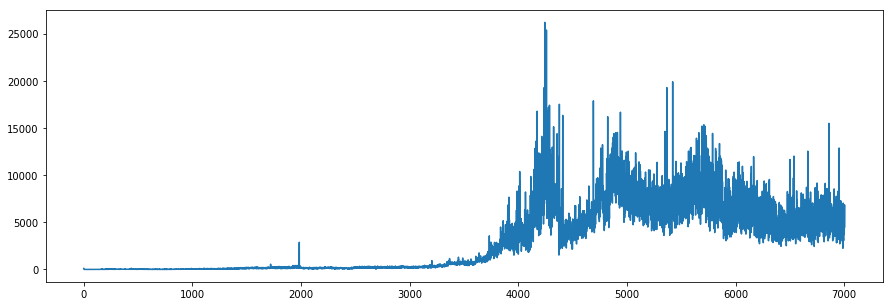

In [342]:
plt.figure(figsize=(15, 5))
plt.plot(addresses_activity_df["range"], addresses_activity_df["activity"])